# Installations and Imports

In [24]:
!sudo apt-get update
!pip install imageio
!sudo apt-get install -y xvfb ffmpeg
!pip3 install gymnasium[classic_control]
!pip install imageio-ffmpeg

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists

In [25]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
import gymnasium as gym
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utility functions for rendering evironment

In [26]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [27]:
def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(DEVICE)
                action = policy(state)
                state, reward, terminated, truncated, _ = env.step(action.item())
                video.append_data(env.render())
                if terminated:
                    break
    return embed_mp4(filename)

# Replay Memory and Q-Network

In [28]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [29]:
# Complete the Q-Network below. 
# The Q-Network takes a state as input and the output is a vector so that each element is the q-value for an action.

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Policies

Now we define 2 policies. We use greedy policy for evaluation and e-greedy during training.

In [30]:
# This function takes in a state and returns the best action according to your q-network.
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network. 

# state shape: (1, state_size) -> output shape: (1, 1)  
def greedy_policy(qnet, state):
    with torch.no_grad():
        q_values = qnet(state)
        action = torch.argmax(q_values, dim=-1, keepdim=True)
    return action

In [31]:
# state shape: (1, state_size) -> output shape: (1, 1)
# Don't forget "torch.no_grad()". We don't want gradient flowing through our network.

def e_greedy_policy(qnet, state, eps_threshold):
    # With probability "eps_threshold" choose a random action 
    # and with probability 1-"eps_threshold" choose the best action according to your Q-Network.
    if random.random() < eps_threshold:
        action = torch.tensor([[random.randrange(2)]], device=DEVICE, dtype=torch.long)
    else:
        with torch.no_grad():
            q_values = qnet(state)
            action = torch.argmax(q_values, dim=-1, keepdim=True)
    
    return action

# Initial setup

In [38]:
BATCH_SIZE = 128
GAMMA = torch.tensor(0.9, device=DEVICE)
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode='rgb_array')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
q_network = DQN(n_observations, n_actions).to(device)
target_network = DQN(n_observations, n_actions).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=LR)
memory = ReplayMemory(10000)

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "random_agent")

# Training

 10%|█         | 1002/10000 [01:09<14:15, 10.52it/s]


Mean reward in last 1000 episodes: 22.619 -- eps:0.8191887203567859


 20%|██        | 2002/10000 [03:12<16:34,  8.04it/s]


Mean reward in last 1000 episodes: 40.397 -- eps:0.7459907357100178


 30%|███       | 3001/10000 [05:38<15:11,  7.68it/s]


Mean reward in last 1000 episodes: 47.558 -- eps:0.6797584602768005


 40%|████      | 4001/10000 [08:34<18:09,  5.50it/s]


Mean reward in last 1000 episodes: 57.578 -- eps:0.6198290191831616


 50%|█████     | 5000/10000 [12:14<14:42,  5.67it/s]


Mean reward in last 1000 episodes: 71.861 -- eps:0.5656026184396552


 60%|██████    | 6000/10000 [16:36<16:54,  3.94it/s]


Mean reward in last 1000 episodes: 85.989 -- eps:0.5165365420015177


 70%|██████▉   | 6999/10000 [21:04<08:31,  5.86it/s]


Mean reward in last 1000 episodes: 88.356 -- eps:0.47213972008407823


 80%|████████  | 8001/10000 [26:06<10:42,  3.11it/s]


Mean reward in last 1000 episodes: 98.933 -- eps:0.4319678143713


 90%|█████████ | 9001/10000 [30:14<02:51,  5.81it/s]


Mean reward in last 1000 episodes: 80.303 -- eps:0.3956187709285658


100%|██████████| 10000/10000 [33:59<00:00,  4.90it/s]


Mean reward in last 1000 episodes: 72.696 -- eps:0.36272879631176524
Complete


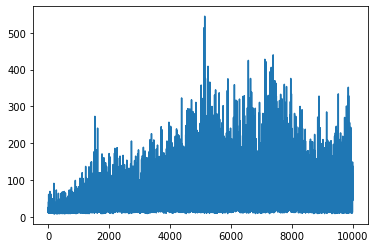

In [40]:
import tqdm

num_episodes = 10000
print_every = 1000
episode_returns = []
episode_durations = []

for i_episode in tqdm.tqdm(range(num_episodes)):

    # ==================================== Your Code (Begin) ====================================
    # 1. Start a new episode
    # 2. Run the environment for 1 step using e-greedy policy
    # 3. Add the (state, action, next_state, reward) to replay memory
    # 4. Optimize your q_network for 1 iteration
    #       4.1 Sample one batch from replay memory
    #       4.2 Compute predicted state-action values using q_network
    #       4.3 Compute expected state-action values using target_network (Don't forget "no_grad" because we don't want gradient through target_network)
    #       4.4 Compute loss function and optimize q_network for 1 step
    # 5. Soft update the weights of target_network
    #       θ′ ← τ θ + (1 −τ )θ′
    #       θ   is q_network weights
    #       θ′  is target_network weights            
    # 6. Keep track of the total reward for each episode to plot later

    # ==================================== Your Code (End) ====================================  
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-i_episode / EPS_DECAY)
    state, info = env.reset()
    total_reward = 0
    for t in count():
        action = e_greedy_policy(q_network, torch.from_numpy(state).unsqueeze(0).to(device), eps_threshold)
        action = action.item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        memory.push((state, action, next_state, reward, terminated))
        if len(memory) > BATCH_SIZE:
            sample = memory.sample(BATCH_SIZE)
            state_batch, action_batch, next_state_batch, reward_batch, is_done_batch = map(np.array, zip(*sample))

            state_batch = torch.from_numpy(state_batch).to(device, dtype=torch.float)
            action_batch = torch.from_numpy(action_batch.astype(np.int64)).to(device)
            next_state_batch = torch.from_numpy(next_state_batch).to(device, dtype=torch.float)
            reward_batch = torch.from_numpy(reward_batch).to(device, dtype=torch.float)
            is_not_done_batch = torch.from_numpy(1 - is_done_batch).to(device)

            q_values = q_network(state_batch)[torch.arange(BATCH_SIZE), action_batch]
            with torch.no_grad():
                next_q_values = target_network(next_state_batch).max(dim=1)[0]
                expected_q_values = (is_not_done_batch * GAMMA * next_q_values) + reward_batch
                
            # what loss function should we use here?
            loss = F.mse_loss(q_values, expected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for target_param, param in zip(target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

        if terminated:
            episode_durations.append(t + 1)
            episode_returns.append(total_reward)
            if (i_episode + 1) % print_every == 0:
                print(f'\nMean reward in last {print_every} episodes: {np.mean(episode_returns[-print_every:])} -- eps:{eps_threshold}')
            break
        state = next_state
    

print('Complete')
plt.plot(range(1, num_episodes+1), episode_durations);

In [41]:
# Render trained model

create_policy_eval_video(env, lambda s: greedy_policy(q_network, s), "trained_agent")